In [2]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import scipy.constants as c
from scipy import stats

from photutils.aperture import CircularAperture
from photutils.detection import DAOStarFinder
from photutils.aperture import aperture_photometry
from photutils.aperture import CircularAnnulus

from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS
from astropy import wcs
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy import units as u

import os
import sys
from astropy.table import Table, join, vstack
from astropy.nddata.utils import extract_array
import pyregion
import tqdm 
import argparse

import integratedflux as flux
from importlib import reload
reload(flux)
import warnings
from astropy.utils.exceptions import AstropyWarning

import time

warnings.filterwarnings('ignore', category=AstropyWarning, append=True)

In [3]:
directory_univ_I = r'/net/vdesk/data2/GoesaertW/Meerkat_Data/Abell_85/I_slices/'
directory_univ_Q = r'/net/vdesk/data2/GoesaertW/Meerkat_Data/Abell_85/Q_slices/'
directory_univ_U = r'/net/vdesk/data2/GoesaertW/Meerkat_Data/Abell_85/U_slices/'

directory_local = r'/data2/goesaert/' 

region_name = "Abell85_catalog_BDSF_rsl.reg"

rsl = fits.open(get_pkg_data_filename(directory_local+'Abell85_catalog_BDSF_rsl.fits'))[1].data

In [4]:
mask = np.load('testmask.npy')

In [9]:
start = time.time()
source_num = len(rsl)
flux_measurements_I = np.zeros((12, source_num))
flux_measurements_Q = np.zeros((12, source_num))
flux_measurements_U = np.zeros((12, source_num))

for i in range(12):
    hdul_image = fits.open(directory_univ_I+'Abell_85_I_plane_freq'+str(i+1)+'.fits')
    for n in tqdm.tqdm(range(source_num)):#range(len(rsl))):
        measurement = flux.integratedflux(directory_local+'Abell_85_I_plane_freq'+str(i+1)+'.fits'\
                                          , np.invert(mask), rsl, n, hdul=hdul_image)
        flux_measurements_I[i,n] = measurement
    hdul_image.close()
print('I is done.')

for i in range(12):
    hdul_image = fits.open(directory_univ_Q+'Abell_85_Q_plane_freq'+str(i+1)+'.fits')
    for n in tqdm.tqdm(range(source_num)):#range(len(rsl))):
        measurement = flux.integratedflux(directory_local+'Abell_85_Q_plane_freq'+str(i+1)+'.fits'\
                                          , np.invert(mask), rsl, n, hdul=hdul_image)
        flux_measurements_Q[i,n] = measurement
    hdul_image.close()
print('Q is done.')

for i in range(12):
    hdul_image = fits.open(directory_univ_U+'Abell_85_U_plane_freq'+str(i+1)+'.fits')
    for n in tqdm.tqdm(range(source_num)):#range(len(rsl))):
        measurement = flux.integratedflux(directory_local+'Abell_85_U_plane_freq'+str(i+1)+'.fits'\
                                          , np.invert(mask), rsl, n, hdul=hdul_image)
        flux_measurements_U[i,n] = measurement
    hdul_image.close()
print('U is done.')

end = time.time()
print("The time of execution of above program is :", end-start)

savedir =r'/net/vdesk/data2/GoesaertW/Meerkat_Data/Abell_85/Photometry_BDSF/'

np.save(savedir+'Abell85_BDSF_I.npy', flux_measurements_I)
np.save(savedir+'Abell85_BDSF_Q.npy', flux_measurements_Q)
np.save(savedir+'Abell85_BDSF_U.npy', flux_measurements_U)

100%|██████████| 4946/4946 [03:49<00:00, 21.58it/s]


I is done.


100%|██████████| 4946/4946 [03:48<00:00, 21.67it/s]


Q is done.


100%|██████████| 4946/4946 [03:44<00:00, 22.08it/s]


U is done.
The time of execution of above program is : 8156.412667274475


In [10]:
Linpol = np.sqrt(flux_measurements_Q**2 + flux_measurements_U**2)
Pol_Angles = 0.5*np.arctan(flux_measurements_U/flux_measurements_Q)

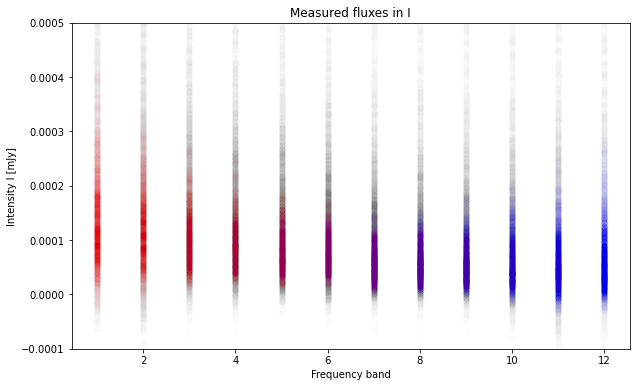

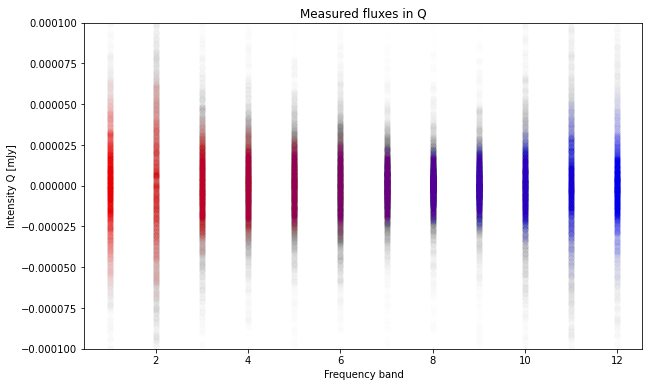

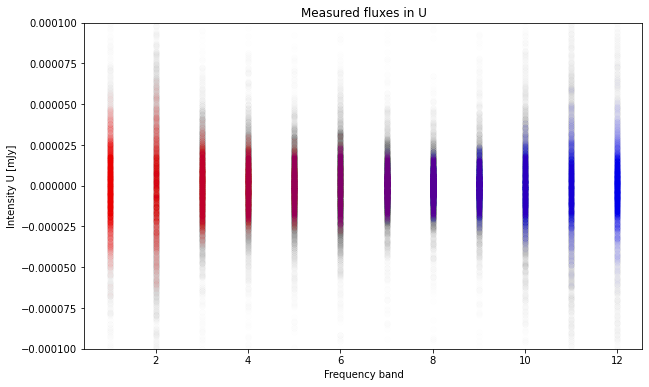

In [13]:
plt.figure(figsize=(10,6))
plt.title('Measured fluxes in I')
for n in range(12):
    plt.scatter((n+1)*np.ones(source_num), flux_measurements_I[n,:], color=((11-n)/12,0,n/12), label='Freq band '+str(n+1), alpha=0.005)
    plt.xlabel('Frequency band')
plt.ylabel('Intensity I [mJy]')
#plt.yscale('log')
#plt.xlim(1e-6, 1e-3)
#plt.ylim(1e-2, 1e2)
plt.ylim(-1e-4, 5e-4)
#plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.title('Measured fluxes in Q')
for n in range(12):
    plt.scatter((n+1)*np.ones(source_num), flux_measurements_Q[n,:], color=((11-n)/12,0,n/12), label='Freq band '+str(n+1), alpha=0.005)
    plt.xlabel('Frequency band')
plt.ylabel('Intensity Q [mJy]')
#plt.xlim(1e-6, 1e-3)
plt.ylim(-1e-4, 1e-4)
#plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.title('Measured fluxes in U')
for n in range(12):
    plt.scatter((n+1)*np.ones(source_num), flux_measurements_U[n,:], color=((11-n)/12,0,n/12), label='Freq band '+str(n+1), alpha=0.005)
    plt.xlabel('Frequency band')
plt.ylabel('Intensity U [mJy]')
#plt.xlim(1e-6, 1e-3)
plt.ylim(-1e-4, 1e-4)
#plt.legend()
plt.show()

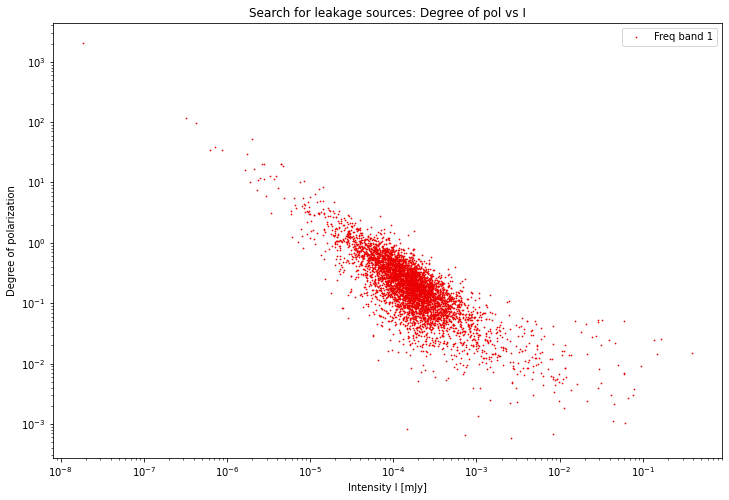

In [15]:
plt.figure(figsize=(12,8))
plt.title('Search for leakage sources: Degree of pol vs I')
for n in range(1):
    plt.scatter(flux_measurements_I[n], Linpol[n]/flux_measurements_I[n], color=((11-n)/12,0,n/12), label='Freq band '+str(n+1), s=0.5)
plt.xlabel('Intensity I [mJy]')
plt.ylabel('Degree of polarization')
plt.yscale('log')
plt.xscale('log')
#plt.xlim(1e-6, 1e-3)
#plt.ylim(1e-2, 1e2)
plt.legend()
plt.show()

In [ ]:
warnings.filterwarnings('ignore', category=AstropyWarning, append=True)
mask = flux.mask_regions(directory_local+'Abell_85_I_plane_freq1.fits', region_name,'/data2/goesaert/testmask.fits', maskoutside=False)

In [ ]:
np.save('testmask.npy', mask)

In [16]:
print "hallo"

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(...)? (<ipython-input-16-23610d4964c0>, line 1)